# BTC Prediction
Began 12/17/18  
Using sklearn modules to make predictions on bitcoin data.

In [1]:
import requests
import io
import os
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import svm

from IPython.display import display

## Data Extraction
Using [1Token.trade](https://1token.trade/) for the bitcoin data. You can find documentation for their api [here](https://1token.trade/docs#/hist-quote/historical-data).

In [2]:
# 1Token's API address
tokenapi = 'http://hist-quote.1tokentrade.cn'

Run the following cell to extract token from `token.txt` in this same directory.  
Can replace this code with just `ot_key = "your 1Token API key"`

In [3]:
# Retrieve API token
current_path = os.getcwd()
with open(current_path + '/token.txt') as file:
    ot_key = file.read().splitlines()[0]

The following two cells are sample 1Token API calls to query all contracts available and single tick data, not used for our analysis.

In [4]:
# Query all contracts for a certain date
# params = {
#     'date' : '2018-02-02',
# }
# r = requests.get(tokenapi + '/ticks/contracts', headers = {'ot-key' : ot_key}, params = params)
# r.json()

In [5]:
# Query a single price at date/contract
# params = {
#     'contract' : 'binance/btc.usdt',
#     'date' : '2018-02-02',
# }
# r = requests.get(tokenapi + '/ticks/simple' , headers = {'ot-key' : ot_key}, params = params)
# r

Querying 1Token's "candle" data.   
Currently querying for the contract 'binance/btx.usdt'.  
I am also writing all the data to a local file `btc-historical-data.csv`, but this is unnecessary.

In [6]:
# Query "candlestick" data
params = {
#     'since' : '2013-12-10',
#     'since' : '2017-12-21',
    'since' : '2018-12-11',
    'until' : '2018-12-21',
    'contract' : 'binance/btc.usdt',
#     'duration' : '1d',
    'duration' : '1m',
    'format' : 'csv'
}
r = requests.get(tokenapi + '/candles' , headers = {'ot-key' : ot_key}, params = params, stream = True)

# Write to local file
df = pd.read_csv(io.StringIO(r.text))   
df.to_csv(current_path + '/btc-historical-data.csv')
print("Number of data points:", df.size / 6)
df.head()

Number of data points: 14400.0


,close,high,low,open,timestamp,volume
0,3433.40,3436.78,3432.39,3434.01,1544486400,19.362386
1,3425.85,3435.26,3424.01,3433.62,1544486460,49.151693
2,3423.26,3431.02,3423.26,3428.00,1544486520,9.487126
3,3425.19,3427.95,3423.57,3424.52,1544486580,10.325669
4,3422.83,3426.81,3422.67,3425.20,1544486640,8.280380


Following cell is just used to plot the current DataFrame:

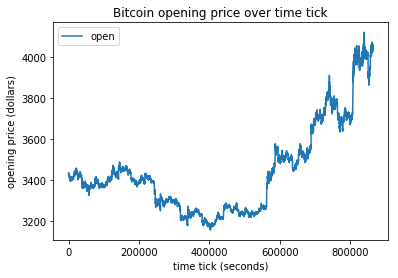

In [7]:
# Plot opening price across entire set
df_plot = df.drop(labels=['close', 'high', 'low', 'volume'], axis=1)
earliest_timestamp = df_plot['timestamp'][0]
# df_plot['timestamp'] = df_plot['timestamp'].apply(lambda x : (x - earliest_timestamp) / 60 / 60 / 24)
df_plot['timestamp'] = df_plot['timestamp'].apply(lambda x : (x - earliest_timestamp))
a = df_plot.plot(x = 'timestamp', y = 'open', \
                     title='Bitcoin opening price over time tick')
a.set_ylabel("opening price (dollars)")
a.set_xlabel("time tick (seconds)")
display(a)

## Data Preparation
We will reduce the features of our data down to "close", "volume", "hl_pct", "pct_change".  
"hl_pct" will stand for high-low percentage - the percent change between the high and low of a given tick.  
"pct_change" will stand for percent change - the percent change between open and close of a given tick.  
I will be trying to predict the closing price `forecast_out` ticks away.
<!--I will be trying to predict the pct_change for a given tick. Positive pct_change will mean a long, negative pct_change will mean a short. -->

In [21]:
df_reduced = df.drop(labels=['timestamp'], axis=1)
df_reduced['hl_pct'] = (df_reduced['high'] - df_reduced['low']) / df_reduced['low'] * 100.0
df_reduced['pct_change'] = (df_reduced['close'] - df_reduced['open']) / df_reduced['open'] * 100.0
df_reduced = df_reduced.drop(labels=['high', 'low', 'open'], axis=1)

forecast_out = 60
forecast_col = 'close'
df_reduced['label'] = df_reduced[forecast_col].shift(-forecast_out)
df_reduced_nonan = df_reduced.dropna(inplace=False)
display(df_reduced_nonan.head())
display(df_reduced_nonan.tail())

,close,volume,hl_pct,pct_change,label
0,3433.40,19.362386,0.127899,-0.017763,3415.54
1,3425.85,49.151693,0.328562,-0.226292,3404.00
2,3423.26,9.487126,0.226685,-0.138273,3406.03
3,3425.19,10.325669,0.127937,0.019565,3406.50
4,3422.83,8.280380,0.120958,-0.069193,3406.35


,close,volume,hl_pct,pct_change,label
14335,4024.39,20.683896,0.134003,0.043752,4057.01
14336,4022.01,20.948302,0.146797,-0.021875,4052.22
14337,4026.32,40.810011,0.218164,0.033292,4052.09
14338,4045.43,47.263655,0.607370,0.475126,4055.36
14339,4043.51,108.259479,0.433078,-0.047214,4049.62


Now, the next step is to split the training/testing data.

In [9]:
percent_training = .8
X = np.array(df_reduced_nonan.drop(['label'], axis=1))
y = np.array(df_reduced_nonan['label'])
# X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - percent_training))
display(X_train.shape)
display(X_test.shape)

(11472, 4)

(2868, 4)

## Train/Test
Now, we can train linear regression model and check its accuracy.

In [47]:
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
accuracy

0.9795601339019457

We can also try regression using svm...

In [45]:
# svm_clf = svm.SVR(kernel='poly', gamma='scale')
svm_clf = svm.SVR(gamma='scale')
svm_clf.fit(X_train, y_train)
accuracy = svm_clf.score(X_test, y_test)
accuracy

0.918196951132054

## Prediction
Now, we can try to predict the last `forecast_out` time ticks.  
Let's say n = `forecast_out`.  
Since we've shifted our labels by n, we can use from the `len(data) - n - n`th tick to the `len(data) - n`th tick to predict the last `n` labels, which are currently `NaN`, to see the classifier in action?

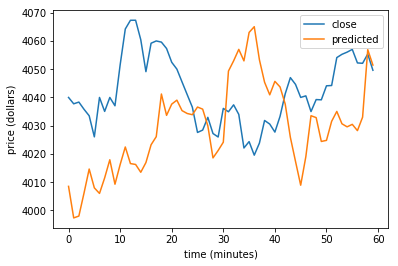

In [62]:
forecast_set = df_reduced[-forecast_out-forecast_out:-forecast_out]
predicted_set = clf.predict(forecast_set.drop('label', axis=1))
actual_set = df_reduced[- forecast_out:].drop(['volume', 'hl_pct', 'pct_change', 'label'], axis=1)
actual_set['index'] = np.arange(len(actual_set))
actual_set['predicted'] = predicted_set
actual_set.set_index('index', inplace=True)

a = actual_set.plot()
a.set_xlabel('time (minutes)')
a.set_ylabel('price (dollars)')
display(a)